Plot graph of guessing entropy

In [1]:
# Choose dataset to plot
# ASCADf | ASCADv
ds = 'ASCADv'

----- Program codes ----

In [2]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src
from src import utils, sca_utils

In [3]:
save_path = f'/workspace/results/ascad/KAN_{ds}'
with hydra.initialize(config_path="../../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN2h",
            "model.model.width.1=5",
            "model.model.width.2=1",
            "model.train_params.steps=7000",
            f"dataset@train={ds}_profiling",
            f"dataset@test={ds}_attack",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            "trace_transforms=void",
            f"save_path={save_path}/0",
            "n_attack_traces=2000",
            ]
        )
model = hydra.utils.instantiate(cfg.model.model)
model.load_ckpt(cfg.model_name+'.ckpt', cfg.save_path)

In [4]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

In [5]:
test_dataset = hydra.utils.instantiate(cfg.test.dataset)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)

In [6]:
correct_key = test_dataset.key[0][cfg.target_byte]
key_hyposesis = range(256)
label_hyposesis = utils.make_label_hyposesis(
    test_dataset, key_hyposesis)

Making label hyposesis [/key hyposesis]: 100%|██████████| 256/256 [24:10<00:00,  5.67s/it]


In [7]:
preds, labels, _ = utils.make_prediction(
        model, test_dataloader, device)
ge_KAN = sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s]


In [8]:
save_path = f'/workspace/results/ascad/MLP_{ds}'
with hydra.initialize(config_path="../../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=MLP_DDLAexp",
            "model.train_params.steps=50000",
            f"dataset@train={ds}_profiling",
            f"dataset@test={ds}_attack",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            "trace_transforms=void",
            f"save_path={save_path}",
            "n_attack_traces=2000",
            ]
        )
model = hydra.utils.instantiate(cfg.model.model)
model.load_state_dict(torch.load(
    Path(cfg.save_path, cfg.model_name+'.pt')))
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
preds, labels, _ = utils.make_prediction(
        model, test_dataloader, device)
ge_MLP = sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:02<00:00, 14.20it/s]


In [10]:
print(np.where(ge_KAN==0)[0])
print(np.where(ge_MLP==0)[0])

[ 476  479  593 ... 1997 1998 1999]
[ 388  389  390 ... 1997 1998 1999]


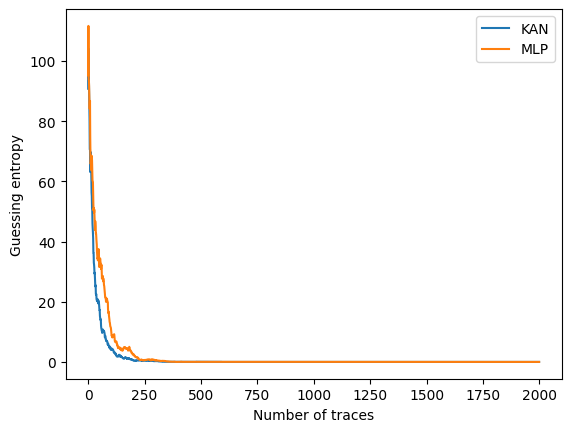

In [11]:
# Save results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge_KAN, label='KAN')
ax.plot(ge_MLP, label='MLP')
ax.set_xlabel('Number of traces')
ax.set_ylabel('Guessing entropy')
plt.legend()
fig.savefig(Path('/workspace/results/ascad/', f'{ds}_GE.png'), dpi=300, bbox_inches='tight')